# Basics of Imaging in Python and NumPy

## Libraries

We use the `Image` class from Pillow (aka PIL, the Python Imaging Library) to do file I/O and image display. For more details, please refer to the [Pillow tutorial](https://pillow.readthedocs.io/en/3.0.x/handbook/tutorial.html).

In [2]:
import numpy as np
from PIL import Image

A couple of tools from IPython (an underlying library related to Jupyter) are useful for displaying images:

In [3]:
from IPython.display import display
from ipywidgets import interact

We also use `matplotlib` as an alternate tool for displaying images.

In [4]:
%matplotlib notebook
import matplotlib
from matplotlib import pyplot as plt

## Loading and displaying images

In [5]:
load_img_path = './inputs/sponge-bob.png'
img = Image.open(load_img_path)

The object returned by `Image.open` is a PIL object that knows how to read the image data from this file when needed.

In [6]:
type(img)

PIL.PngImagePlugin.PngImageFile

The `IPython.display` function can display a PIL image inside Jupyter.

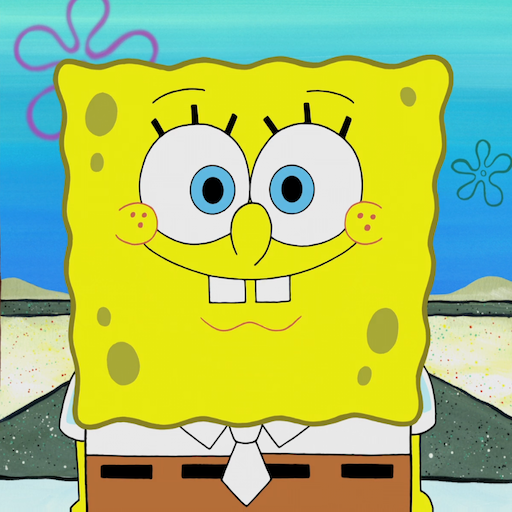

In [7]:
display(img)

## Getting at the image data

Pillow objects provide methods to access image data, but if we convert a PIL image to a NumPy array, then we have more direct access to the pixel data, and all the tools of NumPy available to manipulate it directly.

In [16]:
# Extract pixels:

# Option 1: Load a PixelArray object
pixels = img.load()
print('Value at position (0,0): ', pixels[0,0])


# Option 2: Convert to numpy array
im = np.array(img)
print('Dimensions of array: ', im.shape)
print('Value at position (0,0): ', im[0,0])
array1 = np.array(img)
print(array1[0,0])
inverse = 255 - array1
print(inverse[0,0])


Value at position (0,0):  (95, 217, 210, 255)
Dimensions of array:  (512, 512, 4)
Value at position (0,0):  [ 95 217 210 255]
[ 95 217 210 255]
[160  38  45   0]


With the image in a NumPy array we can use matplotlib as an alternative for displaying images. The benefit is that we can now zoom in/out of the displayed image, and measure colors with mouse hovering.

<IPython.core.display.Javascript object>


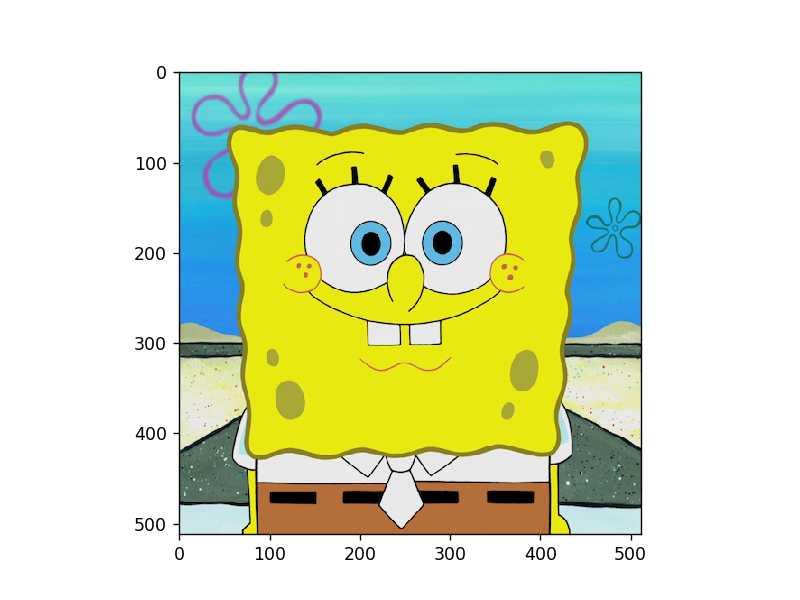

In [9]:
plt.figure()
plt.imshow(im)

A color image to be displayed in this way must have values of type uint8 (therefore in the range $[0,255]$) or float (in which case the displayed range is $[0,1]$).

Alternatively, if we have image data in a NumPy array, we can also display it by constructing a Pillow image and using the `display` function:

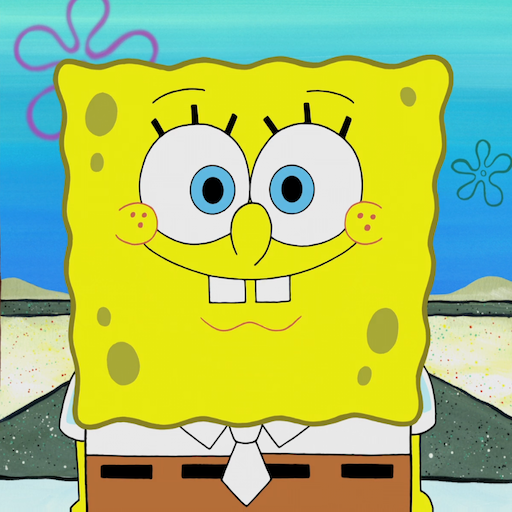

In [10]:
display(Image.fromarray(im))

To display an image this way it needs to be in the `uint8` datatype.  It's pretty easy to convert arrays to floating point without noticing, and if this happens you need to expliclty convert to `uint8`:

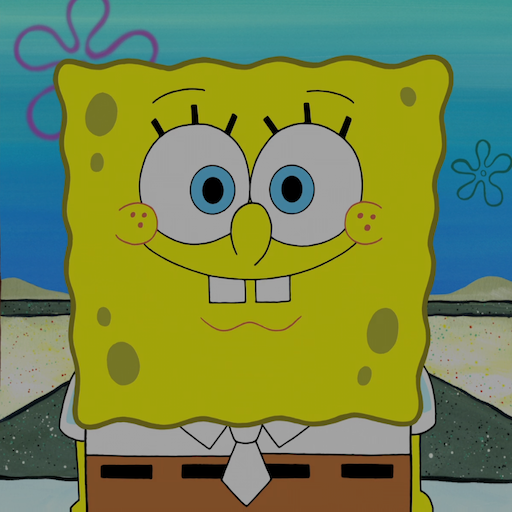

(512, 512, 3)
[231 231 231 255]
(512, 512, 4)


In [75]:
im_dark = 0.7 * im[:,:,:3]  # Note keeping just the RGB channels
#display(Image.fromarray(im_dark))  # TypeError: Cannot handle this data type
display(Image.fromarray(im_dark.astype(np.uint8)))
print(im_dark.astype(np.uint8).shape)
print(im[216,216,0:4])
print(im.shape)
#print(im)

## Manipulating images as arrays

You can implement any imaginable image operation by doing math with the values in the NumPy array.  While it is possible to work with the Pillow Image object directly (e.g. the example below can be done with [this](https://pillow.readthedocs.io/en/3.0.x/handbook/tutorial.html#processing-individual-bands)), in this assignment we always convert the image into a Numpy array so that you are seeing the operations directly rather than just calling the Pillow API.

Now we can apply indexing operations and manipulate the array of pixels.

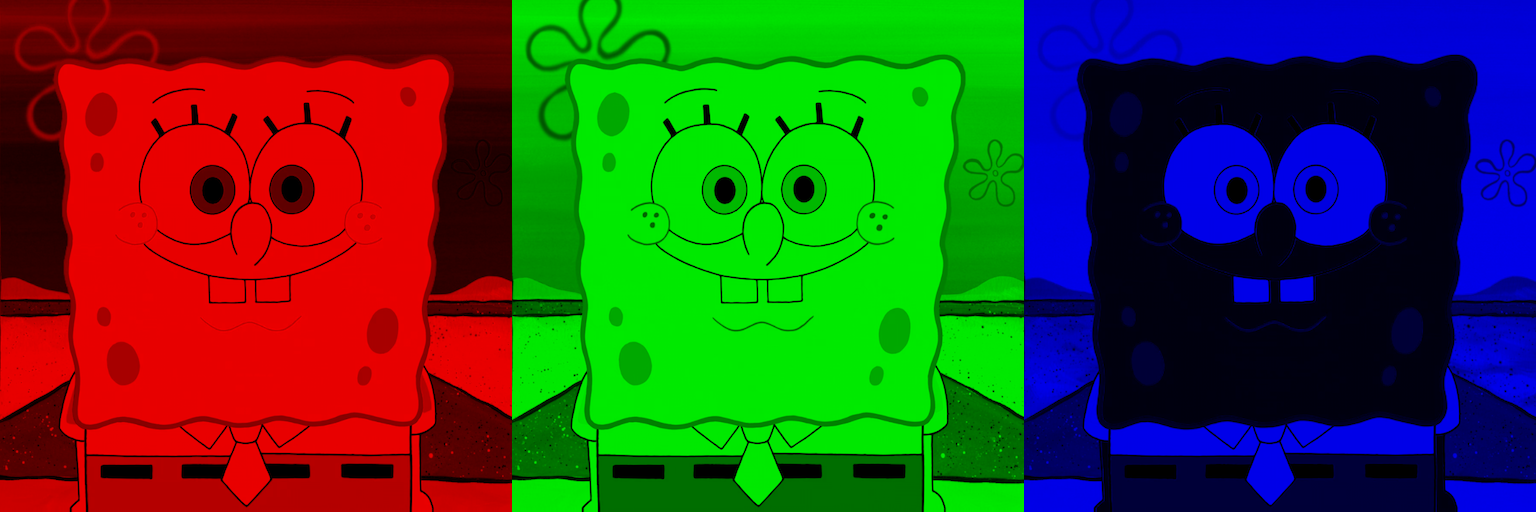

In [11]:
# Example 1: Extract the RGB channels

# Option 1: Indexing the numpy array
im_R = im.copy()
im_R[:, :, (1, 2)] = 0
im_G = im.copy()
im_G[:, :, (0, 2)] = 0
im_B = im.copy()
im_B[:, :, (0, 1)] = 0

# Option 2: Map & convert to list (and back)
im_R1 = np.asarray([[(x[0],0,0,255) for x in y] for y in im])
im_G1 = np.asarray([[(0,x[1],0,255) for x in y] for y in im])
im_B1 = np.asarray([[(0,0,x[2],255) for x in y] for y in im])

assert(np.array_equal(im_R,im_R1))
assert(np.array_equal(im_G,im_G1))
assert(np.array_equal(im_B,im_B1))

im_RGB = np.concatenate((im_R, im_G, im_B), axis=1)

# Convert to uint8 in order to save image as png/jpg
# Here we save the image in RGBA format (same as the loaded image)
# For a complete set of available modes: https://pillow.readthedocs.io/en/4.2.x/handbook/concepts.html#concept-modes
# Note: The mode should correspond to the dimension of the image, e.g. in order to save as RGBA format,
#       each entry im[x,y] should be in the form of (r,g,b,a)
pil_RGB = Image.fromarray(im_RGB.astype(np.uint8), 'RGBA')
pil_RGB.save('./sponge-bob-rgb.png')
display(pil_RGB)

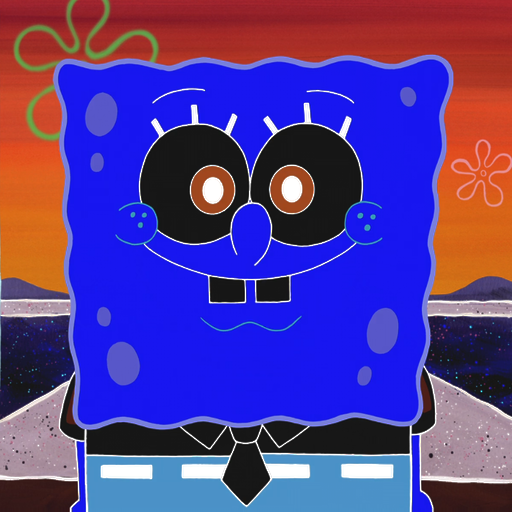

In [22]:
# Example 2: Inverse color

# We can do math operations directly on a multi-dimensional numpy array
im_inverse = 255 - im

# Set the alpha channel back to 255 so the image is opaque
im_inverse[:, :, 3] = 255

pil_inverse = Image.fromarray(im_inverse)
display(pil_inverse)

4


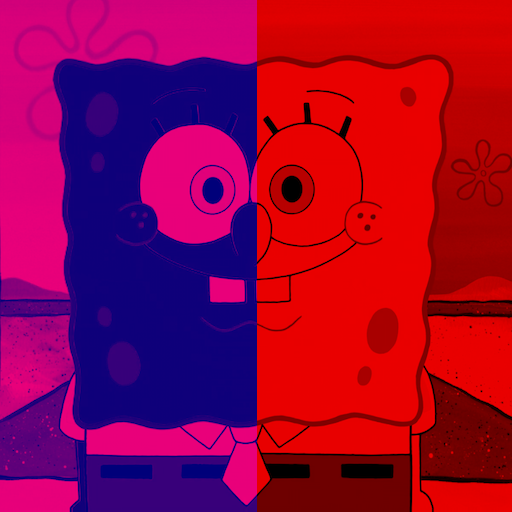

In [24]:
# Example 3: Iterating through pixels
[h,w,rgba] = im.shape
print(rgba)
# Initialize new array and work with RGB channels only
# We want the right half of the image to only contain the red channel
half_r = np.zeros((h,w,3), np.uint8)
#for y in range(h):
#    for x in range(w):
#        if x > w / 2:
#            half_r[y,x] = (im[y,x,0],0,0)
#        else:
#            half_r[y,x] = im[y,x,0:3]
for y in range(h):
    for x in range(w):
        if x > w/2:
            half_r[y,x] = (im[y,x,1],0,0)
        else:
            half_r[y,x] = (im[y,x,2],0,122)
pil_half = Image.fromarray(half_r)
display(pil_half)

## Array operations in NumPy

You can do any computations you like by writing Python code that loops over array indices and computes the results one element at a time.  But NumPy provides a really powerful set of tools for doing arithmetic on arrays, which can let you write more concise, sometimes more readable, and often vastly more efficient code.

The rules are fundamentally pretty simple but things can get confusing pretty fast once you have more than 2 dimensions.  It's worth spending some time with the NumPy documentation to learn about this, but a few examples here can help you get oriented to what is available.

You don't need to use the tricks shown below, but all of them are useful in the imaging assignment and if you master them you can make your code both shorter and much faster.

### Array indexing

Basic indexing of arrays is unsurprising if you are used to regular array indexing in Python.

In [35]:
A = np.array([[1,2,3],[4,5,6],[7,8,9]])   # A.shape is (3,3)
A[0]     # single row of A as a 1D array (shape is (3,), not (1,3))
A[0,:]   # also a single row of A
A[:,0]   # single column of A as a 1D array (shape is (3,), not (3,1))
A[:2,:] # upper right block of 2 rows and 2 columns

array([[1, 2, 3],
       [4, 5, 6]])

You can also supply a list of integers where an index goes &mdash; something you can't do with regular Python lists:

In [37]:
A[[1,2,0],:]  # top and bottom rows (index 0 and 2 along the 0th dimension) of A

array([[4, 5, 6],
       [7, 8, 9],
       [1, 2, 3]])

In [16]:
A[[1],:]   # single row of A as a 1-row 2D array (shape is (1,3))

array([[4, 5, 6]])

In [39]:
A[[0,1],[1,2]]
A

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

You might think this would be the same as `A[:2,1:]`, but when you provide arrays of integers for all the indices, you get an array that is the same shape as the index array, and the input is indexed using corresponding entries of the index arrays.  This is easier to explain with a particular dimension.  Say `I` and `J` are both 2D arrays, and `A` is also a 2D array.  Then `A[I,J]` is an array the same size as `I` and `J` and the same type as `A`, and `A[I,J][k,l]` is a copy of `A[I[k,l],J[k,l]]`.  For example:

In [38]:
I = [[0,1],[1,2]]
J = [[2,1],[1,1]]
A[I,J]

array([[3, 5],
       [5, 8]])

### Componentwise operations

The regular arithmetic operations apply componentwise.  Notice that in the Python 3 tradition, division of integers with `/` is done in floating point.

In [40]:
M = np.array([[3,1,4,1], [5,9,2,6], [5,3,5,8]])
N = np.array([[2,7,1,8], [2,8,1,8], [2,8,4,5]])
print("M\n", M)
print("N\n", N)
print("M + N\n", M + N)
print("M * N\n", M * N)
print("M / N\n", M / N)
print("M // N\n", M // N)

M
 [[3 1 4 1]
 [5 9 2 6]
 [5 3 5 8]]
N
 [[2 7 1 8]
 [2 8 1 8]
 [2 8 4 5]]
M + N
 [[ 5  8  5  9]
 [ 7 17  3 14]
 [ 7 11  9 13]]
M * N
 [[ 6  7  4  8]
 [10 72  2 48]
 [10 24 20 40]]
M / N
 [[1.5        0.14285714 4.         0.125     ]
 [2.5        1.125      2.         0.75      ]
 [2.5        0.375      1.25       1.6       ]]
M // N
 [[1 0 4 0]
 [2 1 2 0]
 [2 0 1 1]]


Scalar multiplication operates as you might expect:

In [41]:
0.5 * M

array([[1.5, 0.5, 2. , 0.5],
       [2.5, 4.5, 1. , 3. ],
       [2.5, 1.5, 2.5, 4. ]])

And other arithmetic operations also apply the scalar to all components:

In [42]:
M - 1

array([[2, 0, 3, 0],
       [4, 8, 1, 5],
       [4, 2, 4, 7]])

In [43]:
M ** 2

array([[ 9,  1, 16,  1],
       [25, 81,  4, 36],
       [25,  9, 25, 64]], dtype=int32)

The array dimensions have to match, but there is a "broadcasting" rule that says any dimension of size 1 will automatically replicate out to the corresponding dimension of the other operand.  For instance, an array of shape (1,1) can be multiplied by any 2D array and implements scalar multiplication:

In [44]:
[[0.5]] * M

array([[1.5, 0.5, 2. , 0.5],
       [2.5, 4.5, 1. , 3. ],
       [2.5, 1.5, 2.5, 4. ]])

To scale a 2D array column by column, multiply by a one-row array:

In [45]:
# Multiplies by:
# [[1, 0, 2, 0],
#  [1, 0, 2, 0],
#  [1, 0, 2, 0]]
[[1,0,2,0]] * M

array([[ 3,  0,  8,  0],
       [ 5,  0,  4,  0],
       [ 5,  0, 10,  0]])

To scale each row, multiply by a one-column array:

In [46]:
# Multiplies by:
# [[1, 1, 1, 1],
#  [0, 0, 0, 0],
#  [2, 2, 2, 2]]
[[1],[0],[2]] * N

array([[ 2,  7,  1,  8],
       [ 0,  0,  0,  0],
       [ 4, 16,  8, 10]])

And the same thing works along a third dimension, and also with other arithmetic operations:

In [47]:
P = np.stack([M,N])
print(P.shape)
s = np.array([[[1,0,2,0]]])
print(s.shape)
P - s

(2, 3, 4)
(1, 1, 4)


array([[[ 2,  1,  2,  1],
        [ 4,  9,  0,  6],
        [ 4,  3,  3,  8]],

       [[ 1,  7, -1,  8],
        [ 1,  8, -1,  8],
        [ 1,  8,  2,  5]]])

A useful tool in getting arrays to broadcast the way you want them to is `newaxis`.  If you index a dimension of an array with this magic symbol, it adds an extra dimension to the array of size 1.  This is best illustrated by example.  Rather than using a ton of list brackets above, I could have used `newaxis` like this:

In [59]:
s = np.array([1,0,2,0])   # shape is (4,)
t = np.array([1,0,2])   # shape is (3,)
M
#N
# Scale the columns (i.e. scale depends on second index)
#s[np.newaxis,:] * M
#s * M
# Scale the rows (scale depends on first index)
t[:,np.newaxis] * N
t[np.newaxis,:,np.newaxis].shape
# Subtract a number that depends on the second index
#P - t[np.newaxis,:,np.newaxis]

(1, 3, 1)

In [60]:
# Subtract a number that depends on the third index
P - s[np.newaxis,np.newaxis,:]

array([[[ 2,  1,  2,  1],
        [ 4,  9,  0,  6],
        [ 4,  3,  3,  8]],

       [[ 1,  7, -1,  8],
        [ 1,  8, -1,  8],
        [ 1,  8,  2,  5]]])

Like arithmetic operations, all manner of math functions also can be applied componentwise, as long as you use the functions from NumPy rather than from the `math` module.

In [61]:
np.sqrt(M)

array([[1.73205081, 1.        , 2.        , 1.        ],
       [2.23606798, 3.        , 1.41421356, 2.44948974],
       [2.23606798, 1.73205081, 2.23606798, 2.82842712]])

In [62]:
np.exp(M - 1)

array([[7.38905610e+00, 1.00000000e+00, 2.00855369e+01, 1.00000000e+00],
       [5.45981500e+01, 2.98095799e+03, 2.71828183e+00, 1.48413159e+02],
       [5.45981500e+01, 7.38905610e+00, 5.45981500e+01, 1.09663316e+03]])

This works pretty transparently so that you can often write code as if it operates on scalars, then apply it componentwise to arrays.

In [63]:
(2 + np.sqrt(M**2 + 2)) / (N + M)

array([[1.06332496, 0.46650635, 1.24852814, 0.41467231],
       [1.02802177, 0.65355492, 1.48316325, 0.58317243],
       [1.02802177, 0.48332953, 0.79957249, 0.77877218]])

### Tensor/matrix type operations

If you have two matrices in arrays and you want to multiply the matrices, this is different from componentwise multiplication.  In NumPy the `@` operator implements matrix multiplication for 2D arrays.

In [68]:
# M @ N  # ValueError: matmul: Input operand 1 has a mismatch in its core dimension .... size 3 is different from 4
# M.transpose() * N  # ValueError: operands could not be broadcast together with shapes (4,3) (3,4) 
M.transpose() @ N
N.transpose() @ M
M

array([[3, 1, 4, 1],
       [5, 9, 2, 6],
       [5, 3, 5, 8]])

The `@` operator can also multiply matrices and vectors, or compute dot products of vectors.

In [69]:
M @ [1,0,2,0]  # Matrix product M v^T

array([11,  9, 15])

In [70]:
[1,0,2] @ M  # Matrix product v M

array([13,  7, 14, 17])

In [73]:
v = np.array([1,2,3])
w = np.array([3,2,1])
v @ w # dot product v^T w
print("M\n", M)
print("N\n", N)

M
 [[3 1 4 1]
 [5 9 2 6]
 [5 3 5 8]]
N
 [[2 7 1 8]
 [2 8 1 8]
 [2 8 4 5]]


A generalization of what the `@` operator does can be achieved by `tensordot`.  It lets you control which axis is being summed and allows summing over more than one axis.  To unpack this a bit: matrix multiplication of matrices $A$ and $B$ computes:

\\[\sum_k A_{ik} B_{kj}\\]

By NumPy counting, $k$ is axis 1 of $A$ and axis 0 of $B$.

In [76]:
np.tensordot(M, N, (0, 0))   # sum_k M_ki N_kj -- same as M.transpose() @ N
np.tensordot(M, N, (1, 1))   # sum_k M_ik N_jk -- same as M @ N.transpose()

array([[ 25,  26,  35],
       [123, 132, 120],
       [100, 103,  94]])

In [ ]:
np.tensordot(P, M, (2,1))  # sum_k P_ijk M_lk -- i.e. compute M @ P[i,j,:] for every i and j

In [ ]:
# Same computation with a Python list comprehension
np.array([[M @ P[i,j,:] for j in range(P.shape[1])] for i in range(P.shape[0])])

In [ ]:
# Same computation with a Python nested loop
A = np.zeros(P.shape[:2] + M.shape[:1], P.dtype)
for i in range (P.shape[0]):
    for j in range (P.shape[1]):
        A[i,j,:] = M @ P[i,j,:]
A

That is a quick tour of matrix operations in NumPy.  It takes a little learning to get accustomed to these tools but once you learn them they are quite powerful.